 goal essayer d'apporter des idées sur pq un hub est un hub. 
 Deux hypothèses : 
 -> Mot très généraux donc plus présent dans les articles (voir la récurrence de chaque mot dans chaque articles)
-> Hub car ton article est plus long, il est plus général, plus de lien a faire 

In [60]:
#NLP libraries
import nltk
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim import corpora
import textstat

#Machine learning libraries
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Helper libraries
import multiprocessing
import numpy as np
import pandas as pd
import math
from bs4 import BeautifulSoup
import re
import os
import seaborn as sns
from collections import defaultdict


In [61]:
# Tester si les fréquences des mots les plus présents dans les paths sont liées à la fréquence d'appartion des mots dans les articles
# Trouves les mots les plus utilisés (repris de Visualisation_wiki)

In [9]:
text_file_dir="./data/wikispeedia_articles_plaintext/plaintext_articles/"


'./data/wikispeedia_articles_plaintext/plaintext_articles/'

In [11]:
PATH="./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_finished.tsv"
PATH_UNFINISHED = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_unfinished.tsv"


finished_path=pd.read_csv(PATH, header=14, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path","rating"])
unfinished_path=pd.read_csv(PATH_UNFINISHED, header=16, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path_start","path_goal","rating"])
finished_path["timestamp"]=pd.to_datetime(finished_path["timestamp"], unit ='s') #convertir le timestamp to datetime
unfinished_path["timestamp"]=pd.to_datetime(unfinished_path["timestamp"], unit ='s') #convertir le timestamp to datetime
finished_path.head()


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [12]:
#code de Adrien#je concatenate tout en une seule chaine de caractère
all_paths_fin = ';'.join(finished_path['path']).split(';')

# je fabrique une liste en supprimant les doublons, je calculerais ensuite la fréquence la dessus
path_fin = list(set(all_paths_fin))


# pas très beau mais bon walla ça marche
path_fin_count = {}
for path in all_paths_fin:
    if path in path_fin_count:
        path_fin_count[path] += 1
    else:
        path_fin_count[path] = 1

path_fin_count
# je vais maintenant chercher les hubs

{'14th_century': 154,
 '15th_century': 187,
 '16th_century': 225,
 'Pacific_Ocean': 844,
 'Atlantic_Ocean': 1324,
 'Accra': 18,
 'Africa': 2796,
 'Atlantic_slave_trade': 105,
 'African_slave_trade': 31,
 'Europe': 4362,
 'Niger': 55,
 'Nigeria': 80,
 'British_Empire': 746,
 'Slavery': 206,
 'Renaissance': 383,
 'Ancient_Greece': 761,
 'Greece': 510,
 'Italy': 867,
 'Roman_Catholic_Church': 499,
 'HIV': 112,
 'Ronald_Reagan': 118,
 'President_of_the_United_States': 850,
 'John_F._Kennedy': 172,
 'North_America': 1884,
 'United_States': 8896,
 'China': 1126,
 'Gunpowder': 96,
 'Fire': 112,
 'Time': 187,
 'Isaac_Newton': 254,
 'Light': 307,
 'Color': 236,
 'Rainbow': 83,
 'Plato': 117,
 'Nature': 244,
 'Ultraviolet': 130,
 'Science': 1497,
 'Weather': 281,
 'Sunlight': 137,
 '<': 20561,
 'Sun': 932,
 'Earth%27s_atmosphere': 380,
 'Christianity': 1097,
 'Bible': 304,
 'God': 457,
 'Optical_fiber': 88,
 'Astronomy': 416,
 'Empiricism': 16,
 'Rain': 208,
 'Leonardo_da_Vinci': 179,
 'Water': 

In [33]:
pages = list(path_fin_count.keys())
counts = list(path_fin_count.values())
top_100_fin_hubs = dict(sorted(path_fin_count.items(), key=lambda item: item[1], reverse=True)[:101])
top_100_fin_hubs
df_top_100_fin_hubs = pd.DataFrame(list(top_100_fin_hubs.items()), columns=['Page', 'Count'])
df_top_100_fin_hubs = df_top_100_fin_hubs.drop(df_top_100_fin_hubs.index[0])
df_top_100_fin_hubs['Normalized_Frequency'] = df_top_100_fin_hubs['Count'] / df_top_100_fin_hubs['Count'].sum()
display(df_top_100_fin_hubs)
#df with top 100 page apparitions in path without "v" and with frequencies (fais peut etre plus de sens de le faire avec tous les mots a voir pour plus tard)


,Page,Count,Normalized_Frequency
1,United_States,8896,0.079179
2,Europe,4362,0.038824
3,United_Kingdom,3904,0.034748
4,England,3332,0.029657
5,Earth,3223,0.028686
...,...,...,...
96,Electricity,522,0.004646
97,Mediterranean_Sea,519,0.004619
98,New_York_City,516,0.004593
99,Oxygen,513,0.004566


In [39]:
def count_hub_appearances(text_file_dir, df_top_100_fin_hubs):
    # Initialize a dictionary to hold the counts
    hub_counts = {hub: 0 for hub in df_top_100_fin_hubs['Page']}
    
    # List all the .txt files in the directory
    for filename in os.listdir(text_file_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(text_file_dir, filename)
            
            # Open and read the file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read().lower()
                
                # Check each hub in the DataFrame
                for hub in hub_counts.keys():
                    hub_name = hub.replace('_', ' ').lower()  # Replace underscores with spaces for the actual text
                    hub_counts[hub] += text.count(hub_name)
    
    # Convert the counts dictionary to a DataFrame
    df_hub_counts = pd.DataFrame(list(hub_counts.items()), columns=['Hub', 'Count'])

    # Calculate the total sum of all counts
    total_count = df_hub_counts['Count'].sum()

    # Avoid division by zero in case total_count is 0
    if total_count > 0:
        # Calculate the normalized frequency
        df_hub_counts['Normalized_Frequency'] = df_hub_counts['Count'] / total_count
    else:
        df_hub_counts['Normalized_Frequency'] = 0

    return df_hub_counts

# Assuming df_top_100_fin_hubs is already defined and contains the top 100 hubs
# Example DataFrame:
# df_top_100_fin_hubs = pd.DataFrame({'Page': ['United_States', 'Europe', ...], 'Count': [8896, 4362, ...]})

# Call the function with the path to your text files and the top 100 hubs DataFrame
text_file_dir = "./data/wikispeedia_articles_plaintext/plaintext_articles/"
df_hub_appearance_counts = count_hub_appearances(text_file_dir, df_top_100_fin_hubs)

# Display the result
display(df_hub_appearance_counts)


,Hub,Count,Normalized_Frequency
0,United_States,7989,0.022804
1,Europe,11826,0.033756
2,United_Kingdom,2400,0.006851
3,England,6170,0.017612
4,Earth,6039,0.017238
...,...,...,...
95,Electricity,638,0.001821
96,Mediterranean_Sea,184,0.000525
97,New_York_City,612,0.001747
98,Oxygen,1104,0.003151


In [44]:
comparison_df = pd.merge(df_top_100_fin_hubs, df_hub_appearance_counts, left_on='Page', right_on='Hub')
display(comparison_df)


,Page,Count_x,Normalized_Frequency_x,Hub,Count_y,Normalized_Frequency_y
0,United_States,8896,0.079179,United_States,7989,0.022804
1,Europe,4362,0.038824,Europe,11826,0.033756
2,United_Kingdom,3904,0.034748,United_Kingdom,2400,0.006851
3,England,3332,0.029657,England,6170,0.017612
4,Earth,3223,0.028686,Earth,6039,0.017238
...,...,...,...,...,...,...
95,Electricity,522,0.004646,Electricity,638,0.001821
96,Mediterranean_Sea,519,0.004619,Mediterranean_Sea,184,0.000525
97,New_York_City,516,0.004593,New_York_City,612,0.001747
98,Oxygen,513,0.004566,Oxygen,1104,0.003151


In [56]:
df_top_100_fin_hubs = df_top_100_fin_hubs.rename(columns={'Count': 'path_appearence'})
df_top_100_fin_hubs = df_top_100_fin_hubs.rename(columns={'Normalized_Frequency': 'N_Frequency_hubs'})

df_hub_appearance_counts = df_hub_appearance_counts.rename(columns={'Hub': 'Page'})
df_hub_appearance_counts = df_hub_appearance_counts.rename(columns={'Normalized_Frequency': 'N_Frequency_hubs_article'})

merged_df = pd.merge(df_top_100_fin_hubs, df_hub_appearance_counts, on='Page')

display(merged_df)

,Page,path_appearence,N_Frequency_hubs,Count,N_Frequency_hubs_article
0,United_States,8896,0.079179,7989,0.022804
1,Europe,4362,0.038824,11826,0.033756
2,United_Kingdom,3904,0.034748,2400,0.006851
3,England,3332,0.029657,6170,0.017612
4,Earth,3223,0.028686,6039,0.017238
...,...,...,...,...,...
95,Electricity,522,0.004646,638,0.001821
96,Mediterranean_Sea,519,0.004619,184,0.000525
97,New_York_City,516,0.004593,612,0.001747
98,Oxygen,513,0.004566,1104,0.003151


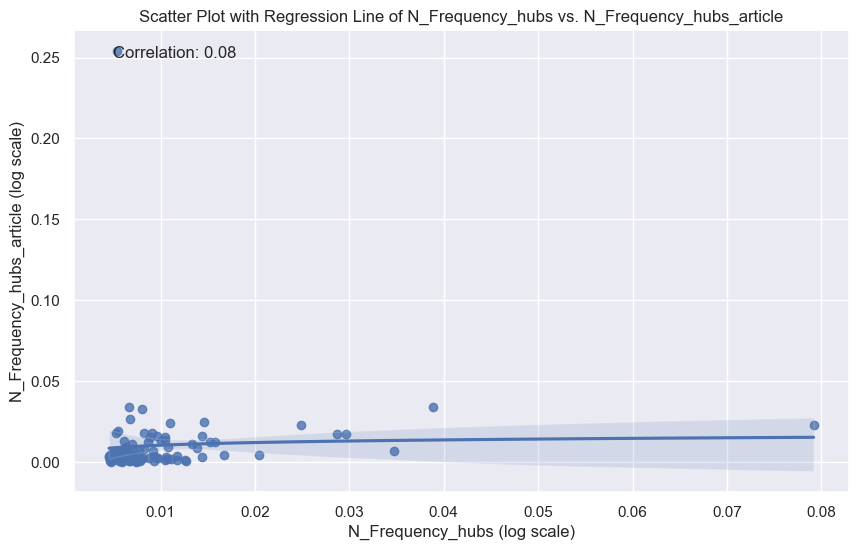

In [62]:
# Calculate correlation coefficient
correlation = merged_df['N_Frequency_hubs'].corr(merged_df['N_Frequency_hubs_article'])

# Create a scatter plot with a regression line
sns.set_theme(color_codes=True)  # Use seaborn theme for nicer-looking plots
plt.figure(figsize=(10, 6))

# Use seaborn regplot to plot data and a regression model fit
sns.regplot(x='N_Frequency_hubs', y='N_Frequency_hubs_article', data=merged_df, logx=True)

# Annotate with the correlation coefficient
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', ha='left', va='center', transform=plt.gca().transAxes)

# Create a title and labels
plt.title('Scatter Plot with Regression Line of N_Frequency_hubs vs. N_Frequency_hubs_article')
plt.xlabel('N_Frequency_hubs (log scale)')
plt.ylabel('N_Frequency_hubs_article (log scale)')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [67]:
import plotly.express as px

fig = px.scatter(merged_df, 
                 x='N_Frequency_hubs', 
                 y='N_Frequency_hubs_article', 
                 hover_data=['Page'], 
                 log_x=True, log_y=True, 
                 title='Interactive Scatter Plot of N_Frequency_hubs vs. N_Frequency_hubs_article')

# Show the plot
fig.show()

